# Regression Representation Demo: CHEMBL2147_Ki (Z extraction + visualization)

This notebook is fully runnable end-to-end for the regression task **CHEMBL2147_Ki**:

1) Load a trained ArcMol regression model from exported artifacts (`.bundle.pt`, `.pth`)
2) Extract **unit-normalized latent representations Z** for train/test splits
3) Visualize Z using three complementary views:
   - t-SNE (2D)
   - 2D spherical map (longitude/latitude)
   - 3D floating sphere projection

**Definition of Z**  
Given fused representation `x = model.encode(...)`, we compute:
- `z_raw = proj(x)`
- `Z = normalize(z_raw)` (unit sphere)


In [1]:
import os

TASK_NAME = "CHEMBL2147_Ki"

DATA_DIR = "/home/data/zou/CMD-/CMD-ADMET/dataset/moleculeACE/CHEMBL2147_Ki/"
BUNDLE_PATH = "CHEMBL2147_Ki/best_arcmol_arc_reg_RDKFingerprint+MACCSkeys+EStateFingerprint+MolT5+BioT5+AttrMask+GPT-GNN+GraphCL+MolCLR+GraphMVP+GROVER+UniMolV1+UniMolV2_84M+UniMolV2_1.1B_seed42.bundle.pt"   # 你实际的 .pt
CKPT_PATH   = "CHEMBL2147_Ki/best_arcmol_arc_reg_RDKFingerprint+MACCSkeys+EStateFingerprint+MolT5+BioT5+AttrMask+GPT-GNN+GraphCL+MolCLR+GraphMVP+GROVER+UniMolV1+UniMolV2_84M+UniMolV2_1.1B_seed42.pth"         # 你实际的 .pth

OUT_DIR = "./z_features_output_CHEMBL2147_Ki_test"
os.makedirs(OUT_DIR, exist_ok=True)

print("OUT_DIR:", os.path.abspath(OUT_DIR))


OUT_DIR: /home/data/zou/CMD-/CMD-ADMET/CMD-ADMET/Few_shot/ARCMOL/z_features_output_CHEMBL2147_Ki_test


## Import model components (only two project files)

For transparency, the notebook only imports the model/fusion definitions from:
- `main_arcmol_mcc_r2.py`
- `attention_pooling_fusion.py`

All remaining logic (Z extraction, saving, plotting) is written directly in this notebook.


In [2]:
import sys
import torch

sys.path.append(os.getcwd())

from attention_pooling_fusion import AttentionPoolingFusion
from main_arcmol_mcc_r2 import (
    set_seed,
    filter_data_for_training,
    extract_rdkit_and_target,
    extract_selected_embedding,
    create_loader,
    TaskAwareDescriptorPooling,
    ArcMolModel,
)

print("Imported OK (2 files).")


Imported OK (2 files).


## Load exported bundle and checkpoint

The exported bundle contains:
- task metadata (regression)
- RDKit feature selection (`topk_idx`) + scaler
- fusion embedding types
- model hyperparameters

We rebuild the exact model structure and load the checkpoint weights.


In [3]:
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

bundle = torch.load(BUNDLE_PATH, map_location="cpu")
seed = int(bundle.get("seed", 24))
set_seed(seed)

task_type = bundle["task"]["task_type"]         # should be "reg"
target_name = bundle["task"]["target_name"]
fusion_embed_types = bundle["fusion_embed_types"]

attributes = bundle["rdkit"]["attribute_names"]
topk = bundle["rdkit"]["topk_idx"]
scaler = bundle["rdkit"]["scaler"]
model_hparams = bundle["model_hparams"]

assert task_type == "reg", f"Expected regression task, got: {task_type}"

# Build modules
in_dim_desc = len(topk)
desc_module = TaskAwareDescriptorPooling(in_dim=in_dim_desc, h=128, out_dim=64, drop=0.1).to(device)

fusion_module = AttentionPoolingFusion(
    used_embedding_types=fusion_embed_types,
    l_output_dim=model_hparams["fusion_out_dim"],
    hidden_dim=model_hparams["fusion_hidden_dim"],
    dropout_prob=model_hparams["fusion_dropout"],
    comp_mode=model_hparams["comp_mode"],
    cka_gamma=model_hparams["cka_gamma"],
    task_gate=model_hparams["task_gate"],
    task_ctx_dim=model_hparams["task_ctx_dim"],
    comp_scale=model_hparams["comp_scale"],
    top_k=model_hparams["moe_topk"],
    sparse_lambda=model_hparams["moe_sparse_lambda"],
).to(device)

in_dim = model_hparams["fusion_out_dim"] + 64

model = ArcMolModel(
    fusion_module,
    desc_module,
    in_dim=in_dim,
    task_type=task_type,
    num_classes=1,
    task_ctx_dim=model_hparams["task_ctx_dim"],
    use_task_ctx=bool(model_hparams["use_task_ctx"]),
    margin=model_hparams["margin"],
    scale=model_hparams["scale"],
    head_hidden=model_hparams["head_hidden"],
    head_dropout=model_hparams["head_dropout"],
    proxy_dropout=model_hparams["proxy_dropout"],
    arc_reg_use=bool(model_hparams.get("arc_reg_use", True)),
    arc_reg_nbins=model_hparams.get("arc_reg_nbins", 32),
    arc_reg_margin=model_hparams.get("arc_reg_margin", 0.10),
    arc_reg_scale=model_hparams.get("arc_reg_scale", 16.0),
    arc_reg_soft_sigma=model_hparams.get("arc_reg_soft_sigma", 0.0),
).to(device)

state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state, strict=True)
model.eval()

print("Model loaded. task_type =", task_type, "| embed_types =", len(fusion_embed_types))


device: cuda
Model loaded. task_type = reg | embed_types = 14


## Extract normalized latent representations Z

For each batch:
1) compute fused representation `x = model.encode(...)`
2) apply regression projection head `z_raw = model.arc_reg.proj(x)`
3) normalize: `Z = z_raw / ||z_raw||`

We then save `{"features": Z, "y_true": y}` into `*_z_features.pkl`.


In [4]:
import torch.nn.functional as F

@torch.no_grad()
def extract_features_epoch_Z_reg(model, loader, device):
    model.eval()

    if not hasattr(model, "arc_reg") or model.arc_reg is None or not hasattr(model.arc_reg, "proj"):
        raise RuntimeError("Regression proj head not found: expected model.arc_reg.proj")

    proj_module = model.arc_reg.proj

    Z_list, Y_list = [], []
    for (emb_dict, d), y in loader:
        emb_dict = {k: v.to(device) for k, v in emb_dict.items()}
        d = d.to(device)
        y = y.to(device)

        x, _ = model.encode(emb_dict, d)
        z_raw = proj_module(x)
        z = F.normalize(z_raw, dim=-1)

        Z_list.append(z.detach().cpu().numpy())
        Y_list.append(y.detach().cpu().numpy())

    Z = np.concatenate(Z_list, axis=0)
    Y = np.concatenate(Y_list, axis=0)
    return Z, Y


## Process train/test splits and save `*_z_features.pkl`

We:
- load the split `.pkl`
- filter invalid entries
- compute RDKit descriptors and apply the exported scaler + selected top-k indices
- build a dataloader
- extract Z and save output files


In [5]:
import pickle

def load_split_raw(data_dir, task_name, split):
    p = os.path.join(data_dir, f"{task_name}_{split}.pkl")
    if not os.path.exists(p):
        raise FileNotFoundError(p)
    with open(p, "rb") as f:
        return pickle.load(f)

def process_split_and_save_reg(split_name: str):
    raw_data = load_split_raw(DATA_DIR, TASK_NAME, split_name)

    filtered = filter_data_for_training(raw_data, fusion_embed_types, target=target_name)
    print(f"[{split_name}] after filter:", len(filtered))
    if len(filtered) == 0:
        raise RuntimeError(f"No valid samples in {split_name}")

    # RDKit features -> select topk -> scale
    X, y_raw = extract_rdkit_and_target(filtered, attributes, target=target_name, task_type="reg")
    X_sel = X[:, topk]
    X_sel = scaler.transform(X_sel)
    desc = torch.tensor(X_sel, dtype=torch.float32)

    # embeddings + y for loader
    emb, y_for_loader = extract_selected_embedding(filtered, fusion_embed_types, target=target_name, task_type="reg")

    loader = create_loader(emb, desc, y_for_loader, bs=128, shuffle=False)

    Z, _ = extract_features_epoch_Z_reg(model, loader, device)

    out_path = os.path.join(OUT_DIR, f"{TASK_NAME}_{split_name}_z_features.pkl")
    with open(out_path, "wb") as f:
        pickle.dump({"features": Z, "y_true": y_raw}, f)

    print(f"Saved: {out_path} | Z shape={Z.shape}")
    return out_path

train_pkl = process_split_and_save_reg("train")
test_pkl  = process_split_and_save_reg("test")


[train] after filter: 1162
Saved: ./z_features_output_CHEMBL2147_Ki_test/CHEMBL2147_Ki_train_z_features.pkl | Z shape=(1162, 192)
[test] after filter: 294
Saved: ./z_features_output_CHEMBL2147_Ki_test/CHEMBL2147_Ki_test_z_features.pkl | Z shape=(294, 192)


## Prepare visualization inputs

The plotting code expects fixed filenames in the current working directory:
- `CHEMBL2147_Ki_train_z_features.pkl`
- `CHEMBL2147_Ki_test_z_features.pkl`

So we copy the extracted outputs here for reproducibility.


In [6]:
import shutil

shutil.copyfile(train_pkl, f"{TASK_NAME}_train_z_features.pkl")
shutil.copyfile(test_pkl,  f"{TASK_NAME}_test_z_features.pkl")

print("Ready in cwd:",
      f"{TASK_NAME}_train_z_features.pkl",
      f"{TASK_NAME}_test_z_features.pkl")


Ready in cwd: CHEMBL2147_Ki_train_z_features.pkl CHEMBL2147_Ki_test_z_features.pkl


In [7]:
import pickle
import numpy as np

def sanity_check_z_pkl(path: str, name: str):
    with open(path, "rb") as f:
        d = pickle.load(f)
    Z = np.asarray(d["features"])
    y = np.squeeze(np.asarray(d["y_true"])).astype(float)

    norms = np.linalg.norm(Z, axis=1)
    print(f"== {name} ==")
    print("Z shape:", Z.shape)
    print("mean ||Z||:", float(norms.mean()))
    print("std  ||Z||:", float(norms.std()))
    print("y stats: min/mean/max =", float(y.min()), float(y.mean()), float(y.max()))
    print()

sanity_check_z_pkl(f"{TASK_NAME}_train_z_features.pkl", "TRAIN")
sanity_check_z_pkl(f"{TASK_NAME}_test_z_features.pkl", "TEST")



== TRAIN ==
Z shape: (1162, 192)
mean ||Z||: 1.0
std  ||Z||: 3.9680820407284045e-08
y stats: min/mean/max = -5.0 -1.150566349189533 2.0

== TEST ==
Z shape: (294, 192)
mean ||Z||: 1.0
std  ||Z||: 3.8080010256180685e-08
y stats: min/mean/max = -4.699999809265137 -1.1227165394063507 2.0



## Visualization 1: t-SNE (regression)

We visualize Z using t-SNE:

- Color encodes regression value (diverging colormap: low → mid → high)
- Train samples are semi-transparent circles
- Test samples are highlighted as diamonds with grey edges

A colorbar is included for reference.


Saved: tsne_regression_diverging_with_legend.png


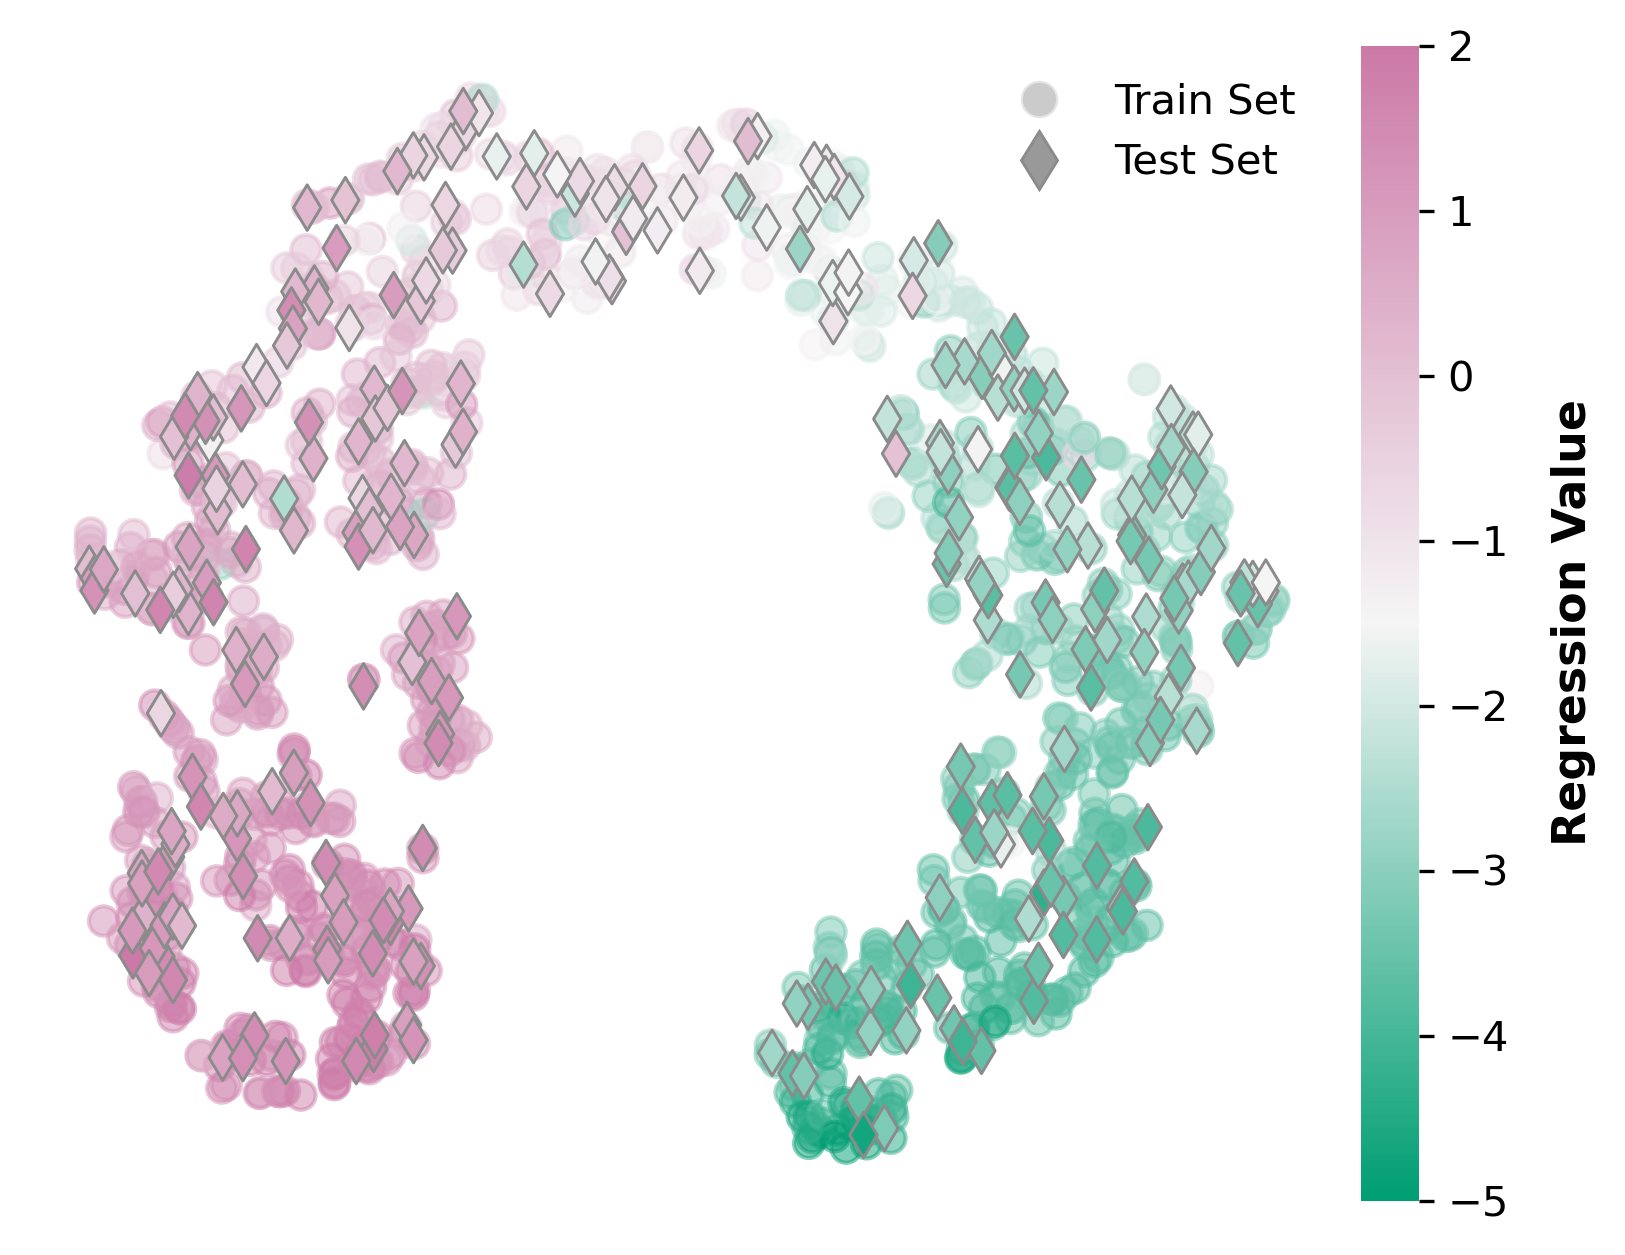

In [8]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
from IPython.display import Image, display

# plt.rcParams.update({"font.family": "Arial", "axes.unicode_minus": False})

TSNE_CFG = {
    "col_low": "#009E73",
    "col_mid": "#F5F5F5",
    "col_high": "#CC79A7",
    "marker_train": "o",
    "marker_test": "d",
    "s_train": 50,
    "alpha_train": 0.5,
    "s_test": 60,
    "alpha_test": 1.0,
    "edge_test": "#8B8B8B",
    "linewidth_test": 0.7,
    "figsize": (6, 5),
    "dpi": 300,
}

def make_diverging_cmap(low, mid, high):
    return mcolors.LinearSegmentedColormap.from_list("diverging_map", [low, mid, high], N=256)

def axis_off(ax):
    ax.set_xticks([]); ax.set_yticks([])
    for sp in ["top", "right", "left", "bottom"]:
        ax.spines[sp].set_visible(False)

def load_reg_data(train_path, test_path):
    all_features, all_labels, all_splits = [], [], []

    for split, path in [("train", train_path), ("test", test_path)]:
        with open(path, "rb") as f:
            d = pickle.load(f)
        feat = np.asarray(d["features"])
        lab  = np.squeeze(d["y_true"]).astype(float)

        all_features.append(feat)
        all_labels.append(lab)
        all_splits.extend([split] * len(lab))

    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    splits = np.array(all_splits)
    return X, y, splits

train_path = f"{TASK_NAME}_train_z_features.pkl"
test_path  = f"{TASK_NAME}_test_z_features.pkl"

X, y, splits = load_reg_data(train_path, test_path)

tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
X_2d = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize=TSNE_CFG["figsize"], dpi=TSNE_CFG["dpi"])

cmap = make_diverging_cmap(TSNE_CFG["col_low"], TSNE_CFG["col_mid"], TSNE_CFG["col_high"])
norm = plt.Normalize(vmin=float(y.min()), vmax=float(y.max()))

mask_train = (splits == "train")
mask_test  = (splits == "test")

sc_train = ax.scatter(
    X_2d[mask_train, 0], X_2d[mask_train, 1],
    c=y[mask_train], cmap=cmap, norm=norm,
    s=TSNE_CFG["s_train"], alpha=TSNE_CFG["alpha_train"],
    marker=TSNE_CFG["marker_train"], zorder=1
)

sc_test = ax.scatter(
    X_2d[mask_test, 0], X_2d[mask_test, 1],
    c=y[mask_test], cmap=cmap, norm=norm,
    s=TSNE_CFG["s_test"], alpha=TSNE_CFG["alpha_test"],
    marker=TSNE_CFG["marker_test"],
    edgecolors=TSNE_CFG["edge_test"], linewidth=TSNE_CFG["linewidth_test"],
    zorder=2
)

axis_off(ax)

# colorbar
cbar = plt.colorbar(sc_test, ax=ax, fraction=0.046, pad=0.02)
cbar.outline.set_visible(False)
cbar.set_label("Regression Value", fontsize=11, labelpad=10, fontweight="bold")

# legend (train vs test)
legend_elements = [
    Line2D([0], [0], marker=TSNE_CFG["marker_train"], color="w", label="Train Set",
           markerfacecolor="#999999", markersize=9, alpha=TSNE_CFG["alpha_train"]),
    Line2D([0], [0], marker=TSNE_CFG["marker_test"], color="w", label="Test Set",
           markerfacecolor="#999999", markersize=10,
           markeredgecolor=TSNE_CFG["edge_test"], markeredgewidth=TSNE_CFG["linewidth_test"]),
]
ax.legend(handles=legend_elements, frameon=False, loc="upper right", fontsize=10)

out_tsne = "tsne_regression_diverging_with_legend.png"
plt.savefig(out_tsne, bbox_inches="tight")
plt.close(fig)
print("Saved:", out_tsne)

display(Image(filename=out_tsne, width=1028))


## Visualization 2: 2D spherical map (longitude/latitude)

We further illustrate the unit-sphere structure of Z:

1) PCA to 3D
2) normalize to the unit sphere
3) convert to longitude/latitude and plot on a 2D map

A **horizontal colorbar** is included (regression value), and a legend indicates train/test.


Saved: spherical_map_regression.png


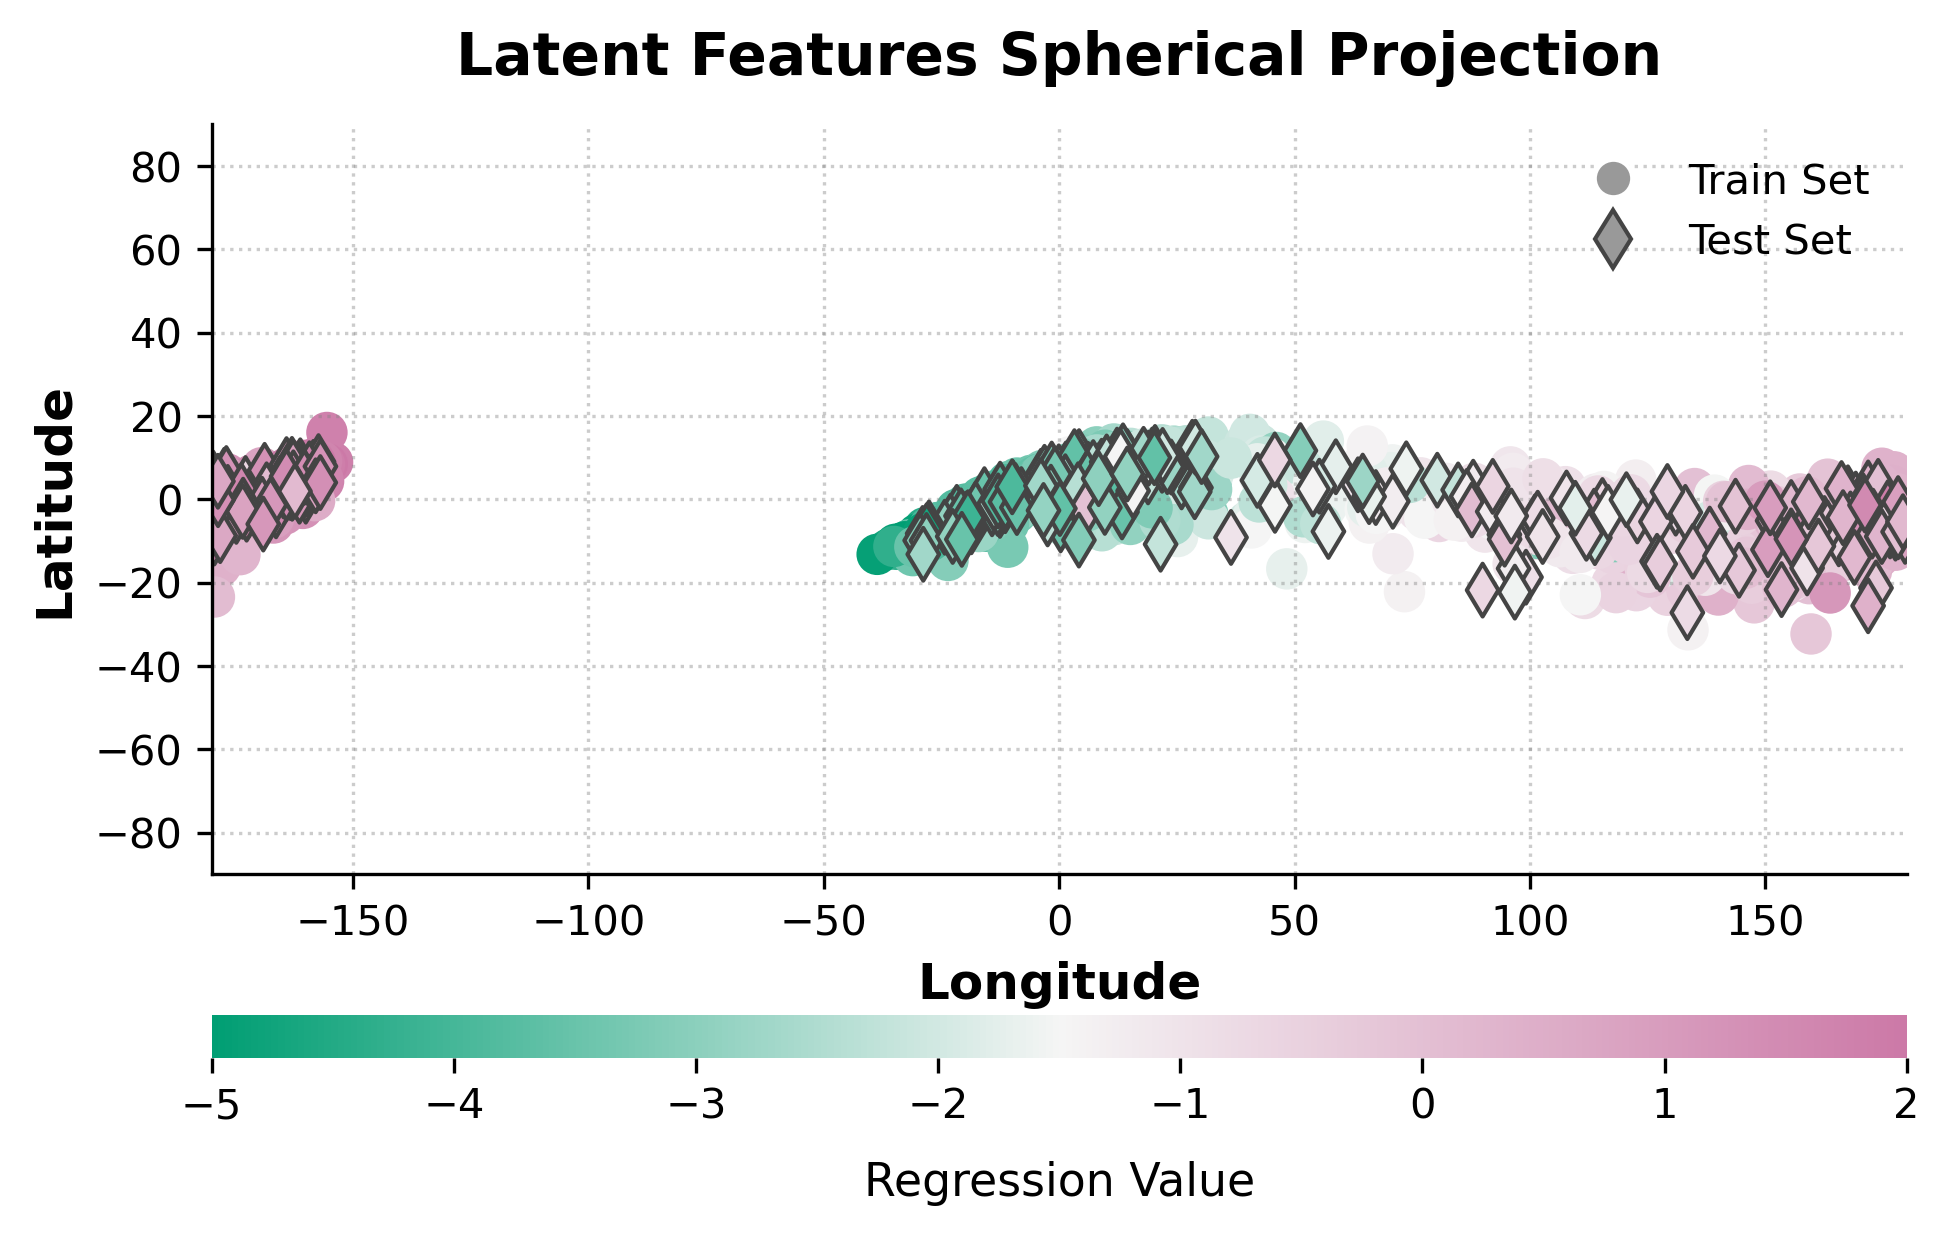

In [9]:
import pandas as pd
from sklearn.decomposition import PCA

SP2D_CFG = {
    "col_low": "#009E73",
    "col_mid": "#F5F5F5",
    "col_high": "#CC79A7",
    "marker_train": "o",
    "s_train": 80,
    "alpha_train": 1.0,
    "marker_test": "d",
    "s_test": 80,
    "alpha_test": 1.0,
    "edge_test": "#444444",
    "lw_test": 1.0,
    "figsize": (6.6, 4.2),
    "dpi": 300,
}

def normalize_features(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.where(norms == 0, 1e-8, norms)

def load_and_project_data_2d_reg(train_path, test_path):
    all_features_norm, all_labels, all_splits = [], [], []

    for split_name, path in [("train", train_path), ("test", test_path)]:
        with open(path, "rb") as f:
            d = pickle.load(f)
        features_X = np.asarray(d["features"])
        labels = np.squeeze(d["y_true"]).astype(float)

        features_Z = normalize_features(features_X)
        all_features_norm.append(features_Z)
        all_labels.append(labels)
        all_splits.extend([split_name] * len(labels))

    Z_combined = np.concatenate(all_features_norm, axis=0)
    y_combined = np.concatenate(all_labels, axis=0)

    pca = PCA(n_components=3, random_state=42)
    Z_3d = pca.fit_transform(Z_combined)

    norms = np.linalg.norm(Z_3d, axis=1, keepdims=True)
    Z_spherical = Z_3d / np.where(norms == 0, 1e-8, norms)

    Xc, Yc, Zc = Z_spherical[:, 0], Z_spherical[:, 1], Z_spherical[:, 2]
    phi = np.arcsin(np.clip(Zc, -1, 1))      # latitude
    theta = np.arctan2(Yc, Xc)               # longitude

    return pd.DataFrame({
        "Longitude": np.degrees(theta),
        "Latitude": np.degrees(phi),
        "Label": y_combined,
        "Split": np.array(all_splits),
    })

df2d = load_and_project_data_2d_reg(train_path, test_path)

fig, ax = plt.subplots(figsize=SP2D_CFG["figsize"], dpi=SP2D_CFG["dpi"])
cmap = make_diverging_cmap(SP2D_CFG["col_low"], SP2D_CFG["col_mid"], SP2D_CFG["col_high"])
norm = plt.Normalize(df2d["Label"].min(), df2d["Label"].max())

mask_train = (df2d["Split"] == "train")
mask_test  = (df2d["Split"] == "test")

sc_train = ax.scatter(
    df2d.loc[mask_train, "Longitude"], df2d.loc[mask_train, "Latitude"],
    c=df2d.loc[mask_train, "Label"], cmap=cmap, norm=norm,
    s=SP2D_CFG["s_train"], alpha=SP2D_CFG["alpha_train"],
    marker=SP2D_CFG["marker_train"], zorder=1
)

sc_test = ax.scatter(
    df2d.loc[mask_test, "Longitude"], df2d.loc[mask_test, "Latitude"],
    c=df2d.loc[mask_test, "Label"], cmap=cmap, norm=norm,
    s=SP2D_CFG["s_test"], alpha=SP2D_CFG["alpha_test"],
    marker=SP2D_CFG["marker_test"],
    edgecolors=SP2D_CFG["edge_test"], linewidth=SP2D_CFG["lw_test"],
    zorder=2
)

ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_xlabel("Longitude", fontsize=12, fontweight="bold")
ax.set_ylabel("Latitude", fontsize=12, fontweight="bold")
ax.set_title("Latent Features Spherical Projection", fontsize=14, fontweight="bold", pad=12)
ax.grid(True, linestyle=":", alpha=0.4, color="gray")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# horizontal colorbar (bottom)
cbar = plt.colorbar(sc_test, ax=ax, orientation="horizontal", fraction=0.05, pad=0.15, aspect=40)
cbar.outline.set_visible(False)
cbar.set_label("Regression Value", fontsize=11, labelpad=8)

# legend
legend_elements = [
    Line2D([0], [0], marker=SP2D_CFG["marker_train"], color="w", label="Train Set",
           markerfacecolor="#999999", markersize=9),
    Line2D([0], [0], marker=SP2D_CFG["marker_test"], color="w", label="Test Set",
           markerfacecolor="#999999", markersize=10,
           markeredgecolor=SP2D_CFG["edge_test"], markeredgewidth=SP2D_CFG["lw_test"]),
]
ax.legend(handles=legend_elements, frameon=False, loc="upper right", fontsize=10)

out2d = "spherical_map_regression.png"
plt.tight_layout()
plt.savefig(out2d, bbox_inches="tight")
plt.close(fig)
print("Saved:", out2d)

display(Image(filename=out2d, width=1028))


## Visualization 3: 3D floating sphere (with colorbar + legend)

We visualize the unit-sphere structure of Z in 3D:

- Wireframe and faint surface indicate the unit sphere geometry
- Faint vector lines show directions from the origin to sampled points (for clarity)
- Train points are semi-transparent circles
- Test points are highlighted diamonds with grey edges
- Color encodes regression value, with a colorbar


Saved: 3d_sphere_regression_with_colorbar.png


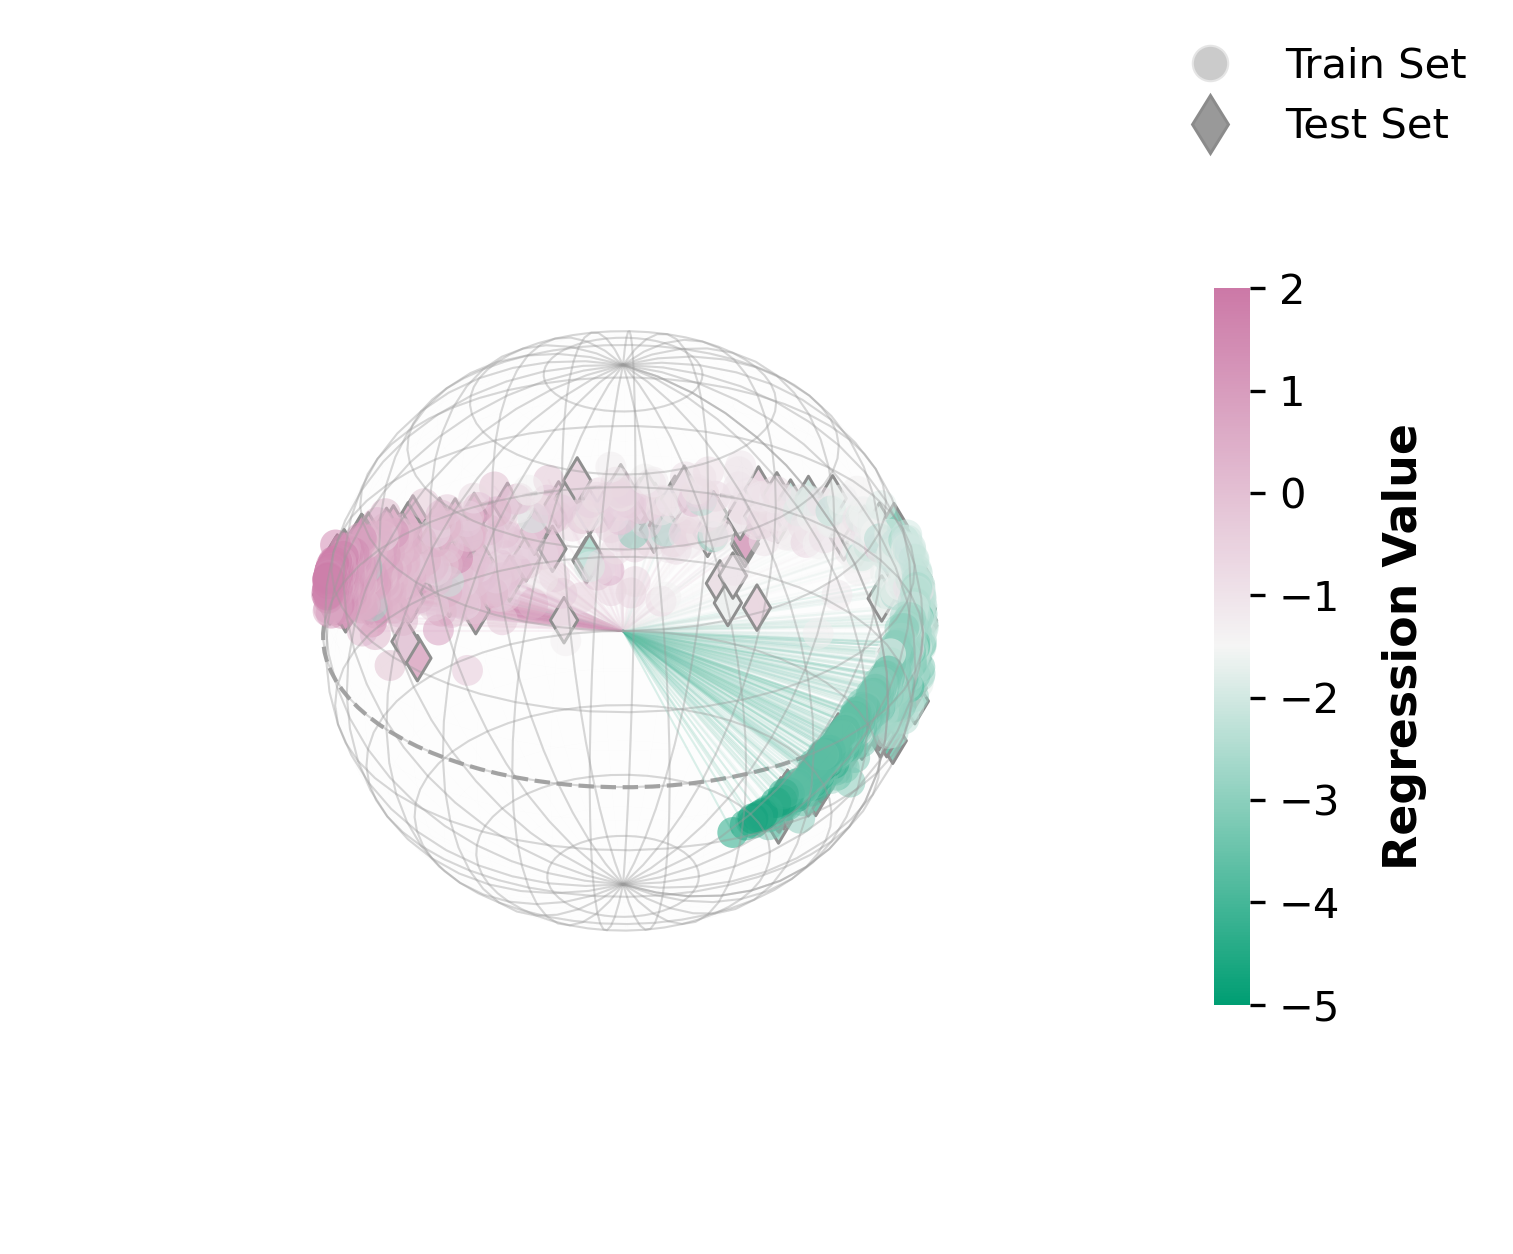

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA

SP3D_CFG = {
    "col_low": "#009E73",
    "col_mid": "#F5F5F5",
    "col_high": "#CC79A7",
    "marker_train": "o",
    "s_train": 55,
    "alpha_train": 0.5,
    "marker_test": "d",
    "s_test": 60,
    "alpha_test": 1.0,
    "edge_test": "#8B8B8B",
    "lw_test": 0.7,
    "figsize": (6.2, 5.0),
    "dpi": 300,
}

def load_data_3d_reg(train_path, test_path):
    all_features, all_labels, all_splits = [], [], []

    for split, path in [("train", train_path), ("test", test_path)]:
        with open(path, "rb") as f:
            d = pickle.load(f)
        feat = np.asarray(d["features"])
        feat = feat / np.linalg.norm(feat, axis=1, keepdims=True)
        lab = np.squeeze(d["y_true"]).astype(float)
        all_features.append(feat)
        all_labels.append(lab)
        all_splits.extend([split] * len(lab))

    X = np.concatenate(all_features, axis=0)
    yv = np.concatenate(all_labels, axis=0)

    pca = PCA(n_components=3, random_state=42)
    X_3d = pca.fit_transform(X)
    X_3d = X_3d / np.linalg.norm(X_3d, axis=1, keepdims=True)

    return pd.DataFrame({
        "X": X_3d[:,0], "Y": X_3d[:,1], "Z": X_3d[:,2],
        "Label": yv,
        "Split": np.array(all_splits),
    })

df3d = load_data_3d_reg(train_path, test_path)

fig = plt.figure(figsize=SP3D_CFG["figsize"], dpi=SP3D_CFG["dpi"])
ax = fig.add_subplot(111, projection="3d")

cmap = make_diverging_cmap(SP3D_CFG["col_low"], SP3D_CFG["col_mid"], SP3D_CFG["col_high"])
norm = plt.Normalize(df3d["Label"].min(), df3d["Label"].max())

# wireframe sphere
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
xs = np.cos(u) * np.sin(v)
ys = np.sin(u) * np.sin(v)
zs = np.cos(v)

ax.plot_wireframe(xs, ys, zs, color="#999999", alpha=0.4, linewidth=0.5, rstride=2, cstride=2)
ax.plot_surface(xs, ys, zs, color="#E0E0E0", alpha=0.03, shade=False)

# equator dashed
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 0, color="#666666", linestyle="--", linewidth=1.0, alpha=0.6)

# vector lines (sample)
MAX_LINES = 500
df_sample = df3d.sample(n=min(len(df3d), MAX_LINES), random_state=42)
for _, row in df_sample.iterrows():
    line_color = cmap(norm(row["Label"]))
    ax.plot([0, row["X"]], [0, row["Y"]], [0, row["Z"]],
            color=line_color, alpha=0.15, linewidth=0.5)

# scatter train/test
mask_train = (df3d["Split"] == "train")
mask_test  = (df3d["Split"] == "test")

sub_train = df3d[mask_train]
sub_test  = df3d[mask_test]

ax.scatter(sub_train["X"], sub_train["Y"], sub_train["Z"],
           c=sub_train["Label"], cmap=cmap, norm=norm,
           marker=SP3D_CFG["marker_train"], s=SP3D_CFG["s_train"],
           alpha=SP3D_CFG["alpha_train"], linewidth=0, zorder=1)

sc = ax.scatter(sub_test["X"], sub_test["Y"], sub_test["Z"],
                c=sub_test["Label"], cmap=cmap, norm=norm,
                marker=SP3D_CFG["marker_test"], s=SP3D_CFG["s_test"],
                alpha=SP3D_CFG["alpha_test"],
                edgecolors=SP3D_CFG["edge_test"], linewidth=SP3D_CFG["lw_test"],
                zorder=10)

ax.set_axis_off()
ax.set_box_aspect([1, 1, 1])

# colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.62, pad=0.02)
cbar.outline.set_visible(False)
cbar.set_label("Regression Value", fontsize=11, labelpad=10, fontweight="bold")

# legend
legend_elements = [
    Line2D([0], [0], marker=SP3D_CFG["marker_train"], color="w", label="Train Set",
           markerfacecolor="#999999", markersize=9, alpha=SP3D_CFG["alpha_train"]),
    Line2D([0], [0], marker=SP3D_CFG["marker_test"], color="w", label="Test Set",
           markerfacecolor="#999999", markersize=10,
           markeredgecolor=SP3D_CFG["edge_test"], markeredgewidth=SP3D_CFG["lw_test"]),
]
fig.legend(handles=legend_elements, loc="upper right",
           bbox_to_anchor=(0.94, 0.92), frameon=False, fontsize=10)

out3d = "3d_sphere_regression_with_colorbar.png"
plt.savefig(out3d, bbox_inches="tight", pad_inches=0.1)
plt.close(fig)
print("Saved:", out3d)

display(Image(filename=out3d, width=1028))


## Summary

In this section, we:
- verified the extracted Z representations via sanity checks (shape + unit-norm)
- produced three regression visualizations with complete legends and colorbars:
  1) t-SNE (diverging colormap)
  2) 2D spherical map (lon/lat + horizontal colorbar)
  3) 3D floating sphere (wireframe + vector lines + colorbar)

These figures are provided to support transparency and reproducibility for peer review.
